# Assessment of Renewable Energy Potentials based on Land Availabilty

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the second stage: **Renewable energy potentials**

-Goal: apply energy parameters onto the available land (output from the first stage).
3. Scenarios: conduct analysis of power generation estimation, capacity, and capacity factor under assumptions.

-Steps:

1. Import data
2. Data unification
3. Setup 3 maps for 3 scenarios
4. Energy parameters (solar and wind)

In [5]:
# import necessary library
%matplotlib inline
import matplotlib.pyplot as plt # graph plotting package
import os # operating system interfaces 
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package
import rasterio # geospatial data (raster file) processing package
import contextily # the package for fetching basemaps
import glob # finds all the pathnames matching a specified pattern
import elevation # for elevation processing
import richdem as rd # package to deal with slope rate
import pyproj # self-defined coordination reference system
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
from geopandas import datasets, GeoDataFrame, read_file # geospatial data processing package
from geopandas.tools import overlay # for overlay function
from shapely import wkt # provide dumpers and loaders inspired by Python’s pickle module
from shapely.geometry import Point # processing for data in point form
from rasterio.merge import merge
from rasterio.plot import show # plot the raster data
from rasterio.plot import show_hist
from rasterstats import zonal_stats
from pyproj import CRS # self-defined coordination reference system
from pyproj import Geod # performs forward and inverse geodetic, or Great Circle, computations
from osgeo import gdal, gdal_array

In [6]:
# spped up the calculation of mapping in shapely library
shapely.speedups.enable()

## 1. Import data

a. Import the **basemap** which is from the **result of stage 1**

b. Import the **map layers** of **open digital elevation model (DEM)** for elevation calculations

c. Import **wind resources** for wind potentials visualization
 
d. Import **solar resources**  for solar potentials visualization

In [7]:
# gdf: geodataframe
# ras: raster file
# 1. Import base map
# Map data from HDX_OCHA
basemap = os.path.abspath('Vietnam/00_data_vector/01_admin_level2/vnm_admbnda_adm2_gov_20201027.shp')
%time map_gdf = geopandas.read_file(basemap)

# 2. Import a. al (available land) (from stgae 1)
al_gdf = geopandas.read_file('Vietnam/01_ouput_stage1/01_vn_available_land.shp')

# 3. import shapefiles of transmission lines
ts_gdf = geopandas.read_file('Vietnam/00_data_vector/08_transmission_lines/TransmissionLine_KV.shp')

Wall time: 322 ms


In [8]:
# open digital elevation model file (Geotiff, raster file)
dem_ras = r"Vietnam/00_data_raster/01_digital_elevaton_model_vn/dem_compress.tif"

# Load the DEM with richdem
rd_dem = rd.LoadGDAL(dem_ras)

In [9]:
# Wind resources
# yearly average wind speed at height 50m
ws_50_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_wind-speed_50m.tif"
# yearly average wind speed at height 100m
ws_100_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_wind-speed_100m.tif"
# yearly average wind speed at height 150m
ws_150_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_wind-speed_150m.tif"
# yearly average wind speed at height 200m
ws_200_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_wind-speed_200m.tif"
# yearly average power density at height 50m
pd_50_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_power-density_50m.tif"
# yearly average power density at height 100m
pd_100_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_power-density_100m.tif"
# yearly average power density at height 150m
pd_150_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_power-density_150m.tif"
# average capacity factor in IEC class 1
cf_ice1_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_capacity-factor_IEC1.tif"
# average capacity factor in IEC class 2
cf_ice2_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_capacity-factor_IEC2.tif"
# average capacity factor in IEC class 3
cf_ice3_ras = r"Vietnam/00_data_raster/03_wind_sources/VNM_capacity-factor_IEC3.tif"

In [10]:
# Solar resources
# GHI: Longterm yearly average of global horizontal irradiation (GHI) in kWh/m2 (Reference information for the assessment of flat-plate PV (photovoltaic) and solar heating technologies (e.g. hot water))
ghi_ras = r"Vietnam/00_data_raster/02_solar_sources/GHI.tif"
# DIF: Longterm yearly average of diffuse horizontal irradiation (DIF) in kWh/m2 (Complementary parameter to GHI and DNI)
dif_ras = r"Vietnam/00_data_raster/02_solar_sources/DIF.tif"
# DNI: Longterm yearly average of direct normal irradiation (DNI) in kWh/m2 (Assessment of Concentrated PV (CPV) and Concentrated Solar Power (CSP) technologies, assessment of flatplate PV)
dni_ras = r"Vietnam/00_data_raster/02_solar_sources/DNI.tif"
# GTI: Longterm yearly average of global irradiation at optimum tilt (GTI) in kWh/m2 (Assessment of solar resource for PV technologies)
gti_ras = r"Vietnam/00_data_raster/02_solar_sources/GTI.tif"
# OPTA: Data layer represents Optimum angle (OPTA) (Optimum tilt to maximaze yearly PV production)
opta_ras = r"Vietnam/00_data_raster/02_solar_sources/OPTA.tif"
# PVOUT: Longterm yearly average of potential photovoltaic electricity production (PVOUT) in kWh/kWp (Assessment of PV power production potential for a free standing PV power plantwith modules mounted at optimum tilt to maximize monthly PV production)
pvout_ras = r"Vietnam/00_data_raster/02_solar_sources/PVOUT.tif"
# TEMP: Longterm yearly average of air temperature (TEMP) in °C
temp_ras = r"Vietnam/00_data_raster/02_solar_sources/TEMP.tif"

## 2. Data Unification

### a. Sort and re-index the **basemap** (**administrative level in Vietnam (VN)**)

In [13]:
print(map_gdf.columns)

Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_VI', 'ADM2_PCODE',
       'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM2ALT1VI', 'ADM2ALT2VI',
       'ADM1_EN', 'ADM1_VI', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_VI', 'ADM0_PCODE',
       'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')


In [14]:
# drop columns that are not needed for calculations
map_drop_gdf = map_gdf.drop(columns=['Shape_Leng','Shape_Area', 'ADM1_VI', 'ADM2_VI', 'ADM2_PCODE', 'ADM2_REF', 
                                           'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM2ALT1VI','ADM2ALT2VI','ADM1_PCODE','ADM0_EN','ADM0_VI','ADM0_PCODE',
                                           'date','validOn','validTo'])
#rename the titles
# create a dictionary
# key = old name
# value = new name
dict = {'NAME_0': 'country_name',
        'NAME_1': 'ad_lv_1',
        'VARNAME_2': 'ad_lv_2',
        'geometry': 'geometry'}
  
# call rename () method
map_drop_gdf.rename(columns=dict,
          inplace=True)
  
map_drop_gdf.head()

,ADM2_EN,ADM1_EN,geometry
0,A Luoi,Thua Thien Hue,"POLYGON ((107.08980 16.44847, 107.09281 16.446..."
1,An Bien,Kien Giang,"POLYGON ((105.12050 9.85495, 105.12673 9.84550..."
2,An Duong,Hai Phong city,"POLYGON ((106.57189 20.93209, 106.57247 20.931..."
3,An Khe,Gia Lai,"POLYGON ((108.68734 14.12817, 108.68975 14.125..."
4,An Lao,Hai Phong city,"POLYGON ((106.48482 20.86676, 106.48501 20.866..."


## 3. Setup maps for 3 Scenarios

[EPSG:4326/WGS 84](https://epsg.io/4326) - World Geodetic System 1984, used in GPS (common longtitude/latitude system) <br>
[EPSG:3405/VN-2000 / UTM zone 48N](https://epsg.io/3405) - Accurate projection and caluclation of areas (units in meters) <br>
*UTM: Universal Transverse Mercator coordinate system

### a. al (available land) (from stgae 1)

In [15]:
# check the CRS of base map
print(al_gdf.crs)

epsg:4326


In [16]:
# crs for meter
# from https://epsg.io/
crs_m = CRS.from_proj4("+proj=utm +zone=48 +ellps=WGS84 +towgs84=-192.873,-39.382,-111.202,-0.00205,-0.0005,0.00335,0.0188 +units=m +no_defs ")
crs_m

<Bound CRS: +proj=utm +zone=48 +ellps=WGS84 +towgs84=-192.873, ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from unknown to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Source CRS: unknown

In [17]:
# 1. a. al (available land) (from stgae 1)
# Get the total land areas
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
# Reprojection to crs
al_m_gdf = al_gdf.to_crs(crs_m)
# Areas in square kilometers
al_km_df = al_m_gdf.area/ 10**6

# Total areas in square kilometers
name = 'Vietnam'
print('Total area of scenario 1 in', name, ':', al_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of scenario 1 in Vietnam : 98024.10436808597 km^2


In [9]:
# Save csv file
# remove column 'geometry' and add column 'area'
al_csv_gdf = al_m_gdf.drop(columns=['geometry'])
al_csv_gdf['area_km2'] = al_km_df

al_csv_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_al.csv', index = True)

### b. al+ts (available land excludes areas whose distances are larger than 10km from existing transmission lines)

In [18]:
# 2. b. al+ts
# remove Id column
ts_drop_gdf = ts_gdf.drop(columns=['Id'])
# ts_meters_gdf = ts_drop_gdf.to_crs("EPSG:3405")
# increase the buffer of road strings (longitude crs. unit in (10 km))
ts_drop_gdf['geometry'] = ts_drop_gdf.geometry.buffer(0.01, cap_style = 3, join_style = 1)
# ts_meters_gdf['geometry'] = ts_meters_gdf.geometry.buffer(1000, cap_style = 3, join_style = 1)
# reprojection back to longtitude latitude crs
# ts_new_gdf = ts_meters_gdf.to_crs("EPSG:4326")
# ts_new_gdf
ts_drop_gdf

<ipython-input-18-f27775a1ae8a>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ts_drop_gdf['geometry'] = ts_drop_gdf.geometry.buffer(0.01, cap_style = 3, join_style = 1)


,Voltage,geometry
0,110,"POLYGON ((104.06851 10.20808, 104.06940 10.208..."
1,110,"POLYGON ((104.80956 10.26948, 104.81051 10.269..."
2,110,"POLYGON ((104.89296 8.98938, 104.89303 8.98976..."
3,110,"POLYGON ((105.13281 9.20153, 105.13256 9.20204..."
4,110,"POLYGON ((105.39562 9.23293, 105.39533 9.23389..."
...,...,...
601,110,"POLYGON ((107.91611 16.34123, 107.91299 16.350..."
602,110,"POLYGON ((107.93956 16.34801, 107.94498 16.356..."
603,110,"POLYGON ((107.96548 16.31833, 107.95785 16.311..."
604,110,"POLYGON ((108.27347 15.95346, 108.27285 15.953..."


In [19]:
# 2. b. al+ts
# Intersection: only the areas include al+es and ts maps
%time al_ts_merge_gdf = geopandas.overlay(al_gdf, ts_drop_gdf,  how = 'intersection')
al_ts_merge_gdf

Wall time: 1.88 s


,ADM2_EN,ADM1_EN,Voltage,geometry
0,An Bien,Kien Giang,110,"MULTIPOLYGON (((105.03238 9.76294, 105.03179 9..."
1,Chau Thanh,Kien Giang,110,"MULTIPOLYGON (((105.15101 9.93831, 105.15088 9..."
2,Hon Dat,Kien Giang,110,"MULTIPOLYGON (((104.76175 10.26940, 104.76000 ..."
3,Kien Luong,Kien Giang,110,"POLYGON ((104.71877 10.26853, 104.71895 10.268..."
4,Tan Hiep,Kien Giang,110,"POLYGON ((105.21924 10.00648, 105.21801 10.007..."
...,...,...,...,...
1214,Yen Dinh,Thanh Hoa,110,"POLYGON ((105.53679 20.02323, 105.53676 20.023..."
1215,Yen Lac,Vinh Phuc,110,"MULTIPOLYGON (((105.55638 21.26943, 105.55663 ..."
1216,Yen Mo,Ninh Binh,110,"MULTIPOLYGON (((105.98443 20.18606, 105.98458 ..."
1217,Yen Son,Tuyen Quang,110,"MULTIPOLYGON (((105.13252 21.75785, 105.13266 ..."


In [20]:
# 2. b. al+ts
# Get the total land areas
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
# Reprojection to crs
al_ts_m_gdf = al_ts_merge_gdf.to_crs(crs_m)
# Areas in square kilometers
al_ts_km_df = al_ts_m_gdf.area/ 10**6

# Total areas in square kilometers
print('Total area of scenario 2 in', name, ':', al_ts_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of scenario 2 in Vietnam : 7621.935794198737 km^2


In [13]:
# Save csv file
# remove column 'geometry' and add column 'area'
al_ts_csv_gdf = al_ts_m_gdf.drop(columns=['geometry'])
al_ts_csv_gdf['area_km2'] = al_ts_km_df

al_ts_csv_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_al_ts.csv', index = True)

In [14]:
# Save the shapefile
al_ts_merge_gdf.to_file(r'Vietnam/02_output_stage2/02_vn_scenario2_al_ts.shp')

### c. al+ts+sl (former two exclude the area whose slope rate is larger than 30%)

In [22]:
# 3.c. al+ts+sl
# Compute slope degree (take elevation varable: rd_dem)
slope = rd.TerrainAttribute(rd_dem, attrib='slope_degrees')

# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
zs = zonal_stats(al_ts_merge_gdf, dem_ras, stats=['mean'])
zs_df = pd.DataFrame(zs)
# zs_df.rename(columns={'mean':'slope_degrees'}, inplace=True)
zs_df.rename(columns={'mean':'slope_degrees'}, inplace=True)
concat_gdf = pd.concat([al_ts_merge_gdf, zs_df], axis=1)
concat_gdf.dropna(axis='rows')

# exclude the slope that is over 30%
al_ts_sl_gdf = concat_gdf[~(concat_gdf['slope_degrees'] > 30)] 

al_ts_sl_drop_gdf = al_ts_sl_gdf.dropna()

# Get the total land areas
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
# Reprojection to crs
al_ts_sl_m_gdf = al_ts_sl_drop_gdf.to_crs(crs_m)
# Areas in square kilometers
al_ts_sl_km_df = al_ts_sl_m_gdf.area/ 10**6

# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', al_ts_sl_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of scenario 3 in Vietnam : 1611.7824709170907 km^2


In [23]:
# Save csv file
# remove column 'geometry' and add column 'area'
al_ts_sl_csv_gdf = al_ts_sl_m_gdf.drop(columns=['geometry'])
al_ts_sl_csv_gdf['area_km2'] = al_ts_sl_km_df

al_ts_sl_csv_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv', index = True)

In [24]:
# Save the shapefile
al_ts_sl_drop_df.to_file(r'Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.shp')

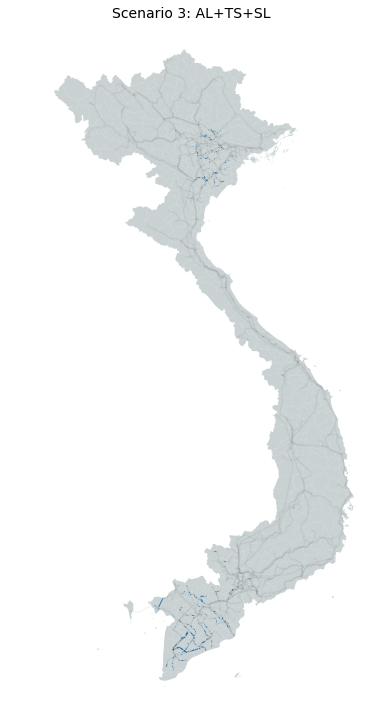

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

# add basemap to the plot (grey)
map_drop_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add basemap to the plot (grey)
# land_area_new_df.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add the transmission layer to the plot (black)
ts_gdf.plot(ax=ax, markersize=10, alpha=0.05, categorical=True, legend=True, color='#17202A')

# add basemap to the plot (default color)
al_ts_sl_drop_df.plot(ax=ax, categorical=True, legend=True)

# Set titles
ax.set_title('Scenario 3: AL+TS+SL', fontsize=14)
ax.set_axis_off()
#catchments_new_pro_gdf.plot(column='slope_degrees', ax=ax, legend=false)

plt.savefig(r'Vietnam/02_output_stage2/02_vn_al_ts_sl.tiff', dpi=500)
plt.tight_layout()

## 4. Energy parameters (solar and wind)

### a. Wind Calculation

In [30]:
# a. scenario 1 al (available land)
%time ws_50_sc1_zs = zonal_stats(al_gdf, ws_50_ras, stats=['mean'])
%time ws_100_sc1_zs = zonal_stats(al_gdf, ws_100_ras, stats=['mean'])
%time ws_150_sc1_zs = zonal_stats(al_gdf, ws_150_ras, stats=['mean'])
%time ws_200_sc1_zs = zonal_stats(al_gdf, ws_200_ras, stats=['mean'])
%time pd_50_sc1_zs = zonal_stats(al_gdf, pd_50_ras, stats=['mean'])
%time pd_100_sc1_zs = zonal_stats(al_gdf, pd_100_ras, stats=['mean'])
%time pd_150_sc1_zs = zonal_stats(al_gdf, pd_150_ras, stats=['mean'])
%time cf_ice1_sc1_zs = zonal_stats(al_gdf, cf_ice1_ras, stats=['mean'])
%time cf_ice2_sc1_zs = zonal_stats(al_gdf, cf_ice2_ras, stats=['mean'])
%time cf_ice3_sc1_zs = zonal_stats(al_gdf, cf_ice3_ras, stats=['mean'])

Wall time: 4.11 s
Wall time: 4.13 s
Wall time: 4.15 s
Wall time: 4.09 s
Wall time: 4.04 s
Wall time: 4.06 s
Wall time: 4.02 s
Wall time: 4.02 s
Wall time: 4.04 s
Wall time: 4.05 s


In [31]:
# transform into dataframe
ws_50_sc1_df = pd.DataFrame(ws_50_sc1_zs)
ws_100_sc1_df = pd.DataFrame(ws_100_sc1_zs)
ws_150_sc1_df = pd.DataFrame(ws_150_sc1_zs)
ws_200_sc1_df = pd.DataFrame(ws_200_sc1_zs)
pd_50_sc1_df = pd.DataFrame(pd_50_sc1_zs)
pd_100_sc1_df = pd.DataFrame(pd_100_sc1_zs)
pd_150_sc1_df = pd.DataFrame(pd_150_sc1_zs)
cf_ice1_sc1_df = pd.DataFrame(cf_ice1_sc1_zs)
cf_ice2_sc1_df = pd.DataFrame(cf_ice2_sc1_zs)
cf_ice3_sc1_df = pd.DataFrame(cf_ice3_sc1_zs)

# rename and put the values in a new column
ws_50_sc1_df.rename(columns={'mean':'ws_h50m_m/s'}, inplace=True)
ws_100_sc1_df.rename(columns={'mean':'ws_h100m_m/s'}, inplace=True)
ws_150_sc1_df.rename(columns={'mean':'ws_h150m_m/s'}, inplace=True)
ws_200_sc1_df.rename(columns={'mean':'ws_h200m_m/s'}, inplace=True)
pd_50_sc1_df.rename(columns={'mean':'power_density_height50m_w/m2'}, inplace=True)
pd_100_sc1_df.rename(columns={'mean':'power_density_height100m_w/m2'}, inplace=True)
pd_150_sc1_df.rename(columns={'mean':'power_density_height150m_w/m2'}, inplace=True)
cf_ice1_sc1_df.rename(columns={'mean':'capacity_factor_iec1'}, inplace=True)
cf_ice2_sc1_df.rename(columns={'mean':'capacity_factor_iec2'}, inplace=True)
cf_ice3_sc1_df.rename(columns={'mean':'capacity_factor_iec3'}, inplace=True)

# concat the columns -> geodataframe
land_w1_sc1_gdf = pd.concat([al_gdf, ws_50_sc1_df], axis=1)
land_w2_sc1_gdf = pd.concat([land_w1_sc1_gdf, ws_100_sc1_df], axis=1)
land_w3_sc1_gdf = pd.concat([land_w2_sc1_gdf, ws_150_sc1_df], axis=1)
land_w4_sc1_gdf = pd.concat([land_w3_sc1_gdf, ws_200_sc1_df], axis=1)
land_w5_sc1_gdf = pd.concat([land_w4_sc1_gdf, pd_50_sc1_df], axis=1)
land_w6_sc1_gdf = pd.concat([land_w5_sc1_gdf, pd_100_sc1_df], axis=1)
land_w7_sc1_gdf = pd.concat([land_w6_sc1_gdf, pd_150_sc1_df], axis=1)
land_w8_sc1_gdf = pd.concat([land_w7_sc1_gdf, cf_ice1_sc1_df], axis=1)
land_w9_sc1_gdf = pd.concat([land_w8_sc1_gdf, cf_ice2_sc1_df], axis=1)
land_w_sc1_gdf = pd.concat([land_w9_sc1_gdf, cf_ice3_sc1_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_w_sc1_drop_gdf = land_w_sc1_gdf.dropna()
land_w_sc1_csv_df = land_w_sc1_drop_gdf.drop(columns=['geometry'])
land_w_sc1_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_wind.csv', index = True)

In [32]:
# b. al+ts (available land + max. 10km from transimission lines)
# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
%time ws_50_sc2_zs = zonal_stats(al_ts_merge_gdf, ws_50_ras, stats=['mean'])
%time ws_100_sc2_zs = zonal_stats(al_ts_merge_gdf, ws_100_ras, stats=['mean'])
%time ws_150_sc2_zs = zonal_stats(al_ts_merge_gdf, ws_150_ras, stats=['mean'])
%time ws_200_sc2_zs = zonal_stats(al_ts_merge_gdf, ws_200_ras, stats=['mean'])
%time pd_50_sc2_zs = zonal_stats(al_ts_merge_gdf, pd_50_ras, stats=['mean'])
%time pd_100_sc2_zs = zonal_stats(al_ts_merge_gdf, pd_100_ras, stats=['mean'])
%time pd_150_sc2_zs = zonal_stats(al_ts_merge_gdf, pd_150_ras, stats=['mean'])
%time cf_ice1_sc2_zs = zonal_stats(al_ts_merge_gdf, cf_ice1_ras, stats=['mean'])
%time cf_ice2_sc2_zs = zonal_stats(al_ts_merge_gdf, cf_ice2_ras, stats=['mean'])
%time cf_ice3_sc2_zs = zonal_stats(al_ts_merge_gdf, cf_ice3_ras, stats=['mean'])

Wall time: 4.09 s
Wall time: 4.07 s
Wall time: 4.16 s
Wall time: 3.98 s
Wall time: 3.95 s
Wall time: 3.86 s
Wall time: 3.85 s
Wall time: 3.92 s
Wall time: 3.89 s
Wall time: 3.92 s


In [33]:
# transform into dataframe
ws_50_sc2_df = pd.DataFrame(ws_50_sc2_zs)
ws_100_sc2_df = pd.DataFrame(ws_100_sc2_zs)
ws_150_sc2_df = pd.DataFrame(ws_150_sc2_zs)
ws_200_sc2_df = pd.DataFrame(ws_200_sc2_zs)
pd_50_sc2_df = pd.DataFrame(pd_50_sc2_zs)
pd_100_sc2_df = pd.DataFrame(pd_100_sc2_zs)
pd_150_sc2_df = pd.DataFrame(pd_150_sc2_zs)
cf_ice1_sc2_df = pd.DataFrame(cf_ice1_sc2_zs)
cf_ice2_sc2_df = pd.DataFrame(cf_ice2_sc2_zs)
cf_ice3_sc2_df = pd.DataFrame(cf_ice3_sc2_zs)

# rename and put the values in a new column
ws_50_sc2_df.rename(columns={'mean':'ws_h50m_m/s'}, inplace=True)
ws_100_sc2_df.rename(columns={'mean':'ws_h100m_m/s'}, inplace=True)
ws_150_sc2_df.rename(columns={'mean':'ws_h150m_m/s'}, inplace=True)
ws_200_sc2_df.rename(columns={'mean':'ws_h200m_m/s'}, inplace=True)
pd_50_sc2_df.rename(columns={'mean':'power_density_height50m_w/m2'}, inplace=True)
pd_100_sc2_df.rename(columns={'mean':'power_density_height100m_w/m2'}, inplace=True)
pd_150_sc2_df.rename(columns={'mean':'power_density_height150m_w/m2'}, inplace=True)
cf_ice1_sc2_df.rename(columns={'mean':'capacity_factor_iec1'}, inplace=True)
cf_ice2_sc2_df.rename(columns={'mean':'capacity_factor_iec2'}, inplace=True)
cf_ice3_sc2_df.rename(columns={'mean':'capacity_factor_iec3'}, inplace=True)

# concat the columns -> geodataframe
land_w1_sc2_gdf = pd.concat([al_ts_merge_gdf, ws_50_sc2_df], axis=1)
land_w2_sc2_gdf = pd.concat([land_w1_sc2_gdf, ws_100_sc2_df], axis=1)
land_w3_sc2_gdf = pd.concat([land_w2_sc2_gdf, ws_150_sc2_df], axis=1)
land_w4_sc2_gdf = pd.concat([land_w3_sc2_gdf, ws_200_sc2_df], axis=1)
land_w5_sc2_gdf = pd.concat([land_w4_sc2_gdf, pd_50_sc2_df], axis=1)
land_w6_sc2_gdf = pd.concat([land_w5_sc2_gdf, pd_100_sc2_df], axis=1)
land_w7_sc2_gdf = pd.concat([land_w6_sc2_gdf, pd_150_sc2_df], axis=1)
land_w8_sc2_gdf = pd.concat([land_w7_sc2_gdf, cf_ice1_sc2_df], axis=1)
land_w9_sc2_gdf = pd.concat([land_w8_sc2_gdf, cf_ice2_sc2_df], axis=1)
land_w_sc2_gdf = pd.concat([land_w9_sc2_gdf, cf_ice3_sc2_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_w_sc2_drop_gdf = land_w_sc2_gdf.dropna()
land_w_sc2_csv_df = land_w_sc2_drop_gdf.drop(columns=['geometry'])
land_w_sc2_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_wind.csv', index = True)

In [34]:
# c. al+ts+sl (from b excluding slop rate larger than 30%)
# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
%time ws_50_sc3_zs = zonal_stats(al_ts_sl_gdf, ws_50_ras, stats=['mean'])
%time ws_100_sc3_zs = zonal_stats(al_ts_sl_gdf, ws_150_ras, stats=['mean'])
%time ws_150_sc3_zs = zonal_stats(al_ts_sl_gdf, ws_150_ras, stats=['mean'])
%time ws_200_sc3_zs = zonal_stats(al_ts_sl_gdf, ws_200_ras, stats=['mean'])
%time pd_50_sc3_zs = zonal_stats(al_ts_sl_gdf, pd_50_ras, stats=['mean'])
%time pd_100_sc3_zs = zonal_stats(al_ts_sl_gdf, pd_100_ras, stats=['mean'])
%time pd_150_sc3_zs = zonal_stats(al_ts_sl_gdf, pd_150_ras, stats=['mean'])
%time cf_ice1_sc3_zs = zonal_stats(al_ts_sl_gdf, cf_ice1_ras, stats=['mean'])
%time cf_ice2_sc3_zs = zonal_stats(al_ts_sl_gdf, cf_ice2_ras, stats=['mean'])
%time cf_ice3_sc3_zs = zonal_stats(al_ts_sl_gdf, cf_ice3_ras, stats=['mean'])

Wall time: 1.63 s
Wall time: 1.6 s
Wall time: 1.59 s
Wall time: 1.62 s
Wall time: 1.51 s
Wall time: 1.61 s
Wall time: 1.57 s
Wall time: 1.57 s
Wall time: 1.54 s
Wall time: 1.6 s


In [35]:
# transform into dataframe
ws_50_sc3_df = pd.DataFrame(ws_50_sc3_zs)
ws_100_sc3_df = pd.DataFrame(ws_100_sc3_zs)
ws_150_sc3_df = pd.DataFrame(ws_150_sc3_zs)
ws_200_sc3_df = pd.DataFrame(ws_200_sc3_zs)
pd_50_sc3_df = pd.DataFrame(pd_50_sc3_zs)
pd_100_sc3_df = pd.DataFrame(pd_100_sc3_zs)
pd_150_sc3_df = pd.DataFrame(pd_150_sc3_zs)
cf_ice1_sc3_df = pd.DataFrame(cf_ice1_sc3_zs)
cf_ice2_sc3_df = pd.DataFrame(cf_ice2_sc3_zs)
cf_ice3_sc3_df = pd.DataFrame(cf_ice3_sc3_zs)

# rename and put the values in a new column
ws_50_sc3_df.rename(columns={'mean':'ws_h50m_m/s'}, inplace=True)
ws_100_sc3_df.rename(columns={'mean':'ws_h100m_m/s'}, inplace=True)
ws_150_sc3_df.rename(columns={'mean':'ws_h150m_m/s'}, inplace=True)
ws_200_sc3_df.rename(columns={'mean':'ws_h200m_m/s'}, inplace=True)
pd_50_sc3_df.rename(columns={'mean':'power_density_height50m_w/m2'}, inplace=True)
pd_100_sc3_df.rename(columns={'mean':'power_density_height100m_w/m2'}, inplace=True)
pd_150_sc3_df.rename(columns={'mean':'power_density_height150m_w/m2'}, inplace=True)
cf_ice1_sc3_df.rename(columns={'mean':'capacity_factor_iec1'}, inplace=True)
cf_ice2_sc3_df.rename(columns={'mean':'capacity_factor_iec2'}, inplace=True)
cf_ice3_sc3_df.rename(columns={'mean':'capacity_factor_iec3'}, inplace=True)

# concat the columns -> geodataframe
land_w1_sc3_gdf = pd.concat([al_ts_sl_gdf, ws_50_sc3_df], axis=1)
land_w2_sc3_gdf = pd.concat([land_w1_sc3_gdf, ws_100_sc3_df], axis=1)
land_w3_sc3_gdf = pd.concat([land_w2_sc3_gdf, ws_150_sc3_df], axis=1)
land_w4_sc3_gdf = pd.concat([land_w3_sc3_gdf, ws_200_sc3_df], axis=1)
land_w5_sc3_gdf = pd.concat([land_w4_sc3_gdf, pd_50_sc3_df], axis=1)
land_w6_sc3_gdf = pd.concat([land_w5_sc3_gdf, pd_100_sc3_df], axis=1)
land_w7_sc3_gdf = pd.concat([land_w6_sc3_gdf, pd_150_sc3_df], axis=1)
land_w8_sc3_gdf = pd.concat([land_w7_sc3_gdf, cf_ice1_sc3_df], axis=1)
land_w9_sc3_gdf = pd.concat([land_w8_sc3_gdf, cf_ice2_sc3_df], axis=1)
land_w_sc3_gdf = pd.concat([land_w9_sc3_gdf, cf_ice3_sc3_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_w_sc3_drop_gdf = land_w_sc3_gdf.dropna()
land_w_sc3_csv_df = land_w_sc3_drop_gdf.drop(columns=['geometry'])
land_w_sc3_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_wind.csv', index = True)

###  Wind Visualizations (take one example)

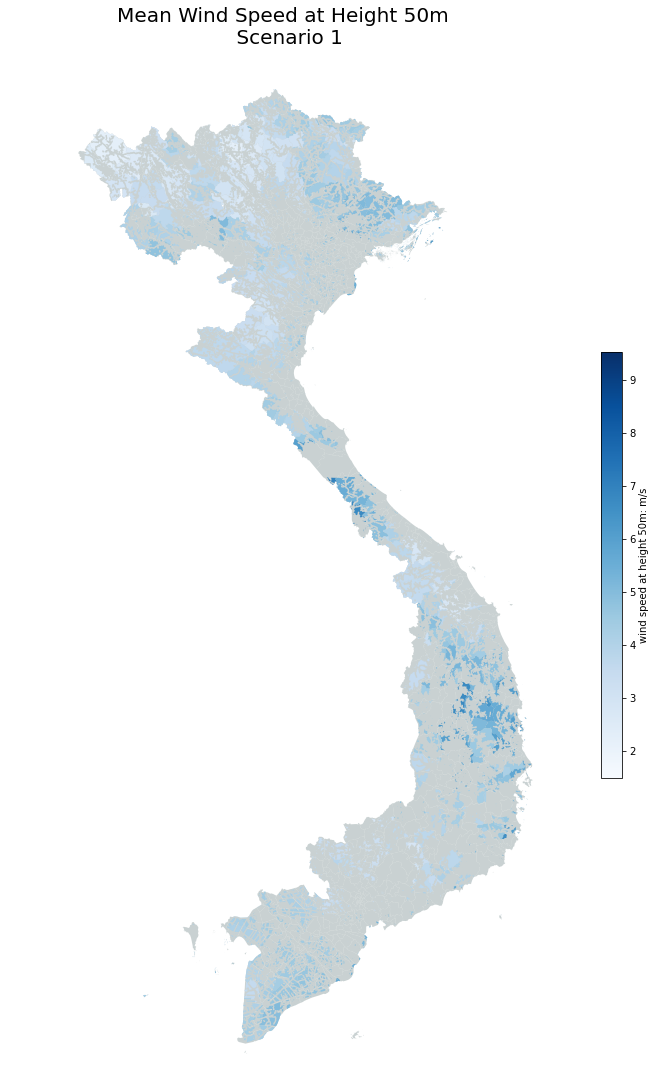

In [32]:
fig, ax = plt.subplots(figsize=(10, 20))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

# add basemap to the plot (grey)
map_drop_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add basemap to the plot (grey)
#land_area_new_df.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')
land_w_sc1_drop_gdf.plot(column='ws_h50m_m/s', ax=ax, cmap='Blues', legend=True, legend_kwds={'shrink': 0.3, 'label': 'wind speed at height 50m: m/s'})

# Set titles
ax.set_title('Mean Wind Speed at Height 50m \n Scenario 1', fontsize=20)
ax.set_axis_off()


plt.savefig(r'Vietnam/02_output_stage2/02_vn_scenario1_wind_speed_h50m.tiff', dpi=500)
plt.tight_layout()

### d. Solar Calculation

In [36]:
# a. scenario 1 al (available land)
# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
%time ghi_sc1_zs = zonal_stats(al_gdf, ghi_ras, stats=['mean'])
%time dif_sc1_zs = zonal_stats(al_gdf, dif_ras, stats=['mean'])
%time dni_sc1_zs = zonal_stats(al_gdf, dni_ras, stats=['mean'])
%time gti_sc1_zs = zonal_stats(al_gdf, gti_ras, stats=['mean'])
%time opta_sc1_zs = zonal_stats(al_gdf, opta_ras, stats=['mean'])
%time pvout_sc1_zs = zonal_stats(al_gdf, pvout_ras, stats=['mean'])
%time temp_sc1_zs = zonal_stats(al_gdf, temp_ras, stats=['mean'])

Wall time: 4.88 s
Wall time: 4.65 s
Wall time: 4.83 s
Wall time: 4.81 s
Wall time: 2.37 s
Wall time: 2.79 s
Wall time: 2.68 s


In [37]:
# transform into dataframe
ghi_sc1_df = pd.DataFrame(ghi_sc1_zs)
dif_sc1_df = pd.DataFrame(dif_sc1_zs)
dni_sc1_df = pd.DataFrame(dni_sc1_zs)
gti_sc1_df = pd.DataFrame(gti_sc1_zs)
opta_sc1_df = pd.DataFrame(opta_sc1_zs)
pvout_sc1_df = pd.DataFrame(pvout_sc1_zs)
temp_sc1_df = pd.DataFrame(temp_sc1_zs)

# rename and put the values in a new column
ghi_sc1_df.rename(columns={'mean':'ghi_kWh/m2a'}, inplace=True)
dif_sc1_df.rename(columns={'mean':'dif_kWh/m2as'}, inplace=True)
dni_sc1_df.rename(columns={'mean':'dni_kWh/m2a'}, inplace=True)
gti_sc1_df.rename(columns={'mean':'gti_kWh/m2a'}, inplace=True)
opta_sc1_df.rename(columns={'mean':'opta_tilt_degree'}, inplace=True)
pvout_sc1_df.rename(columns={'mean':'pvout_kWh/kWp'}, inplace=True)
temp_sc1_df.rename(columns={'mean':'temp_celcius'}, inplace=True)

# concat the columns -> geodataframe
land_s1_sc1_gdf = pd.concat([al_gdf, ghi_sc1_df], axis=1)
land_s2_sc1_gdf = pd.concat([land_s1_sc1_gdf, dif_sc1_df], axis=1)
land_s3_sc1_gdf = pd.concat([land_s2_sc1_gdf, dni_sc1_df], axis=1)
land_s4_sc1_gdf = pd.concat([land_s3_sc1_gdf, gti_sc1_df], axis=1)
land_s5_sc1_gdf = pd.concat([land_s4_sc1_gdf, opta_sc1_df], axis=1)
land_s6_sc1_gdf = pd.concat([land_s5_sc1_gdf, pvout_sc1_df], axis=1)
land_s_sc1_gdf = pd.concat([land_s6_sc1_gdf, temp_sc1_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_s_sc1_drop_gdf = land_s_sc1_gdf.dropna()
land_s_sc1_csv_df = land_s_sc1_drop_gdf.drop(columns=['geometry'])
land_s_sc1_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_solar.csv', index = True)

In [38]:
# b. al+ts (available land + max. 10km from transimission lines)
# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
%time ghi_sc2_zs = zonal_stats(al_ts_merge_gdf, ghi_ras, stats=['mean'])
%time dif_sc2_zs = zonal_stats(al_ts_merge_gdf, dif_ras, stats=['mean'])
%time dni_sc2_zs = zonal_stats(al_ts_merge_gdf, dni_ras, stats=['mean'])
%time gti_sc2_zs = zonal_stats(al_ts_merge_gdf, gti_ras, stats=['mean'])
%time opta_sc2_zs = zonal_stats(al_ts_merge_gdf, opta_ras, stats=['mean'])
%time pvout_sc2_zs = zonal_stats(al_ts_merge_gdf, pvout_ras, stats=['mean'])
%time temp_sc2_zs = zonal_stats(al_ts_merge_gdf, temp_ras, stats=['mean'])

Wall time: 3.45 s
Wall time: 3.19 s
Wall time: 3.27 s
Wall time: 3.27 s
Wall time: 2.01 s
Wall time: 2.22 s
Wall time: 2.15 s


In [39]:
# transform into dataframe
ghi_sc2_df = pd.DataFrame(ghi_sc2_zs)
dif_sc2_df = pd.DataFrame(dif_sc2_zs)
dni_sc2_df = pd.DataFrame(dni_sc2_zs)
gti_sc2_df = pd.DataFrame(gti_sc2_zs)
opta_sc2_df = pd.DataFrame(opta_sc2_zs)
pvout_sc2_df = pd.DataFrame(pvout_sc2_zs)
temp_sc2_df = pd.DataFrame(temp_sc2_zs)

# rename and put the values in a new column
ghi_sc2_df.rename(columns={'mean':'ghi_kWh/m2a'}, inplace=True)
dif_sc2_df.rename(columns={'mean':'dif_kWh/m2as'}, inplace=True)
dni_sc2_df.rename(columns={'mean':'dni_kWh/m2a'}, inplace=True)
gti_sc2_df.rename(columns={'mean':'gti_kWh/m2a'}, inplace=True)
opta_sc2_df.rename(columns={'mean':'opta_tilt_degree'}, inplace=True)
pvout_sc2_df.rename(columns={'mean':'pvout_kWh/kWp'}, inplace=True)
temp_sc2_df.rename(columns={'mean':'temp_celcius'}, inplace=True)

# concat the columns -> geodataframe
land_s1_sc2_gdf = pd.concat([al_ts_merge_gdf, ghi_sc2_df], axis=1)
land_s2_sc2_gdf = pd.concat([land_s1_sc2_gdf, dif_sc2_df], axis=1)
land_s3_sc2_gdf = pd.concat([land_s2_sc2_gdf, dni_sc2_df], axis=1)
land_s4_sc2_gdf = pd.concat([land_s3_sc2_gdf, gti_sc2_df], axis=1)
land_s5_sc2_gdf = pd.concat([land_s4_sc2_gdf, opta_sc2_df], axis=1)
land_s6_sc2_gdf = pd.concat([land_s5_sc2_gdf, pvout_sc2_df], axis=1)
land_s_sc2_gdf = pd.concat([land_s6_sc2_gdf, temp_sc2_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_s_sc2_drop_gdf = land_s_sc2_gdf.dropna()
land_s_sc2_csv_df = land_s_sc2_drop_gdf.drop(columns=['geometry'])
land_s_sc2_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_solar.csv', index = True)

In [40]:
# c. al+ts+sl (from b excluding slop rate larger than 30%)
# a. scenario 1 al (available land)
# The zs variable is a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
%time ghi_sc3_zs = zonal_stats(al_ts_sl_gdf, ghi_ras, stats=['mean'])
%time dif_sc3_zs = zonal_stats(al_ts_sl_gdf, dif_ras, stats=['mean'])
%time dni_sc3_zs = zonal_stats(al_ts_sl_gdf, dni_ras, stats=['mean'])
%time gti_sc3_zs = zonal_stats(al_ts_sl_gdf, gti_ras, stats=['mean'])
%time opta_sc3_zs = zonal_stats(al_ts_sl_gdf, opta_ras, stats=['mean'])
%time pvout_sc3_zs = zonal_stats(al_ts_sl_gdf, pvout_ras, stats=['mean'])
%time temp_sc3_zs = zonal_stats(al_ts_sl_gdf, temp_ras, stats=['mean'])

Wall time: 1.19 s
Wall time: 1.11 s
Wall time: 1.15 s
Wall time: 1.14 s
Wall time: 804 ms
Wall time: 873 ms
Wall time: 918 ms


In [41]:
# transform into dataframe
ghi_sc3_df = pd.DataFrame(ghi_sc3_zs)
dif_sc3_df = pd.DataFrame(dif_sc3_zs)
dni_sc3_df = pd.DataFrame(dni_sc3_zs)
gti_sc3_df = pd.DataFrame(gti_sc3_zs)
opta_sc3_df = pd.DataFrame(opta_sc3_zs)
pvout_sc3_df = pd.DataFrame(pvout_sc3_zs)
temp_sc3_df = pd.DataFrame(temp_sc3_zs)

# rename and put the values in a new column
ghi_sc3_df.rename(columns={'mean':'ghi_kWh/m2a'}, inplace=True)
dif_sc3_df.rename(columns={'mean':'dif_kWh/m2as'}, inplace=True)
dni_sc3_df.rename(columns={'mean':'dni_kWh/m2a'}, inplace=True)
gti_sc3_df.rename(columns={'mean':'gti_kWh/m2a'}, inplace=True)
opta_sc3_df.rename(columns={'mean':'opta_tilt_degree'}, inplace=True)
pvout_sc3_df.rename(columns={'mean':'pvout_kWh/kWp'}, inplace=True)
temp_sc3_df.rename(columns={'mean':'temp_celcius'}, inplace=True)

# concat the columns -> geodataframe
land_s1_sc3_gdf = pd.concat([al_ts_sl_gdf, ghi_sc3_df], axis=1)
land_s2_sc3_gdf = pd.concat([land_s1_sc3_gdf, dif_sc3_df], axis=1)
land_s3_sc3_gdf = pd.concat([land_s2_sc3_gdf, dni_sc3_df], axis=1)
land_s4_sc3_gdf = pd.concat([land_s3_sc3_gdf, gti_sc3_df], axis=1)
land_s5_sc3_gdf = pd.concat([land_s4_sc3_gdf, opta_sc3_df], axis=1)
land_s6_sc3_gdf = pd.concat([land_s5_sc3_gdf, pvout_sc3_df], axis=1)
land_s_sc3_gdf = pd.concat([land_s6_sc3_gdf, temp_sc3_df], axis=1)

# remove column 'geometry' -> become dataframe to save the document
land_s_sc3_drop_gdf = land_s_sc3_gdf.dropna()
land_s_sc3_csv_df = land_s_sc3_drop_gdf.drop(columns=['geometry'])
land_s_sc3_csv_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_solar.csv', index = True)

### d. Solar Visualization (Take One Example)

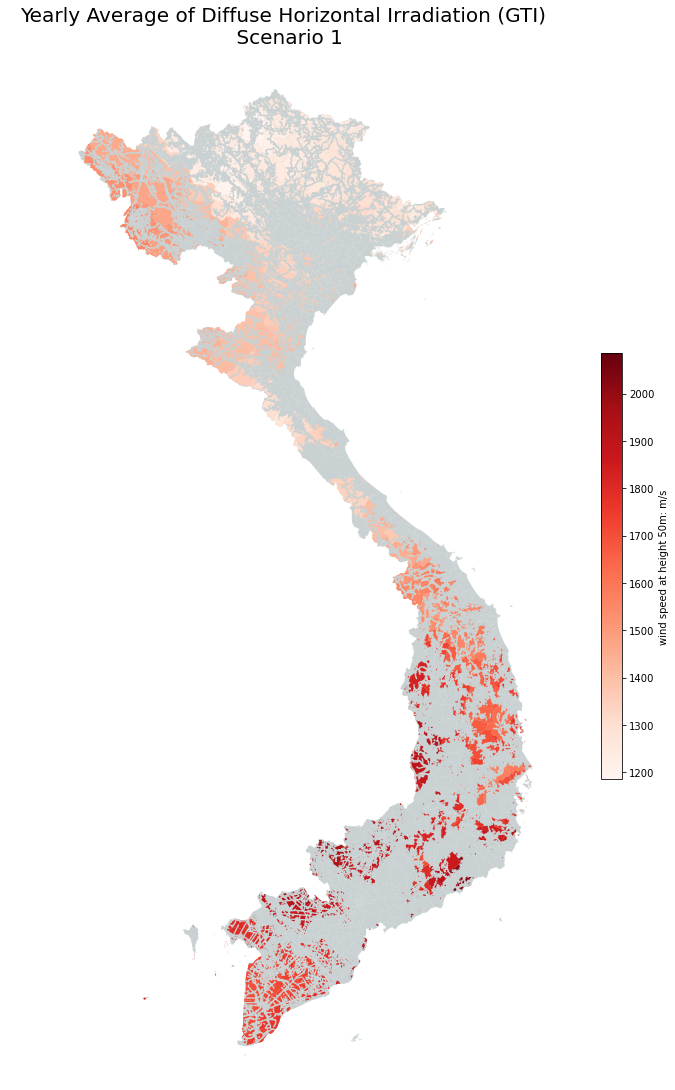

In [39]:
fig, ax = plt.subplots(figsize=(10, 20))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

# add basemap to the plot (grey)
map_drop_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add basemap to the plot (grey)
#land_area_new_df.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')
land_s_sc1_drop_gdf.plot(column='gti_kWh/m2a', ax=ax, cmap='Reds', legend=True, legend_kwds={'shrink': 0.3, 'label': 'wind speed at height 50m: m/s'})

# Set titles
ax.set_title('Yearly Average of Diffuse Horizontal Irradiation (GTI) \n Scenario 1', fontsize=20)
ax.set_axis_off()


plt.savefig(r'Vietnam/02_output_stage2/02_vn_scenario1_solar_gti.tiff', dpi=500)
plt.tight_layout()